In [1]:
from IPython.display import clear_output

In [2]:
!pip install bayesian-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.1 MB/s eta 0:00:00


In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools
import torch
import torch.nn as nn
from torch.autograd import grad
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from mfdl import singlefidelity_NN
from mfdl import multifidelity_NN

from joblib import dump, load

from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tqdm.auto import trange, tqdm

from google.colab import files

np.random.seed(20)

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


In [5]:
# Continuous function with linear correlation

def low_fidelity_linear(A, B, C, x):
    return A*((6*x-2)**2)*np.sin(12*x-4) + B*(x - 0.5) + C

def high_fidelity_linear(x):
    return ((6*x-2)**2)*np.sin(12*x-4)

# Continuous function with non-linear correlation

def low_fidelity_nonlinear(x):
    return np.sin(8*np.pi*x)

def high_fidelity_nonlinear(x, yl):
    return (x-np.sqrt(2))*yl**2

Text(0, 0.5, 'y')

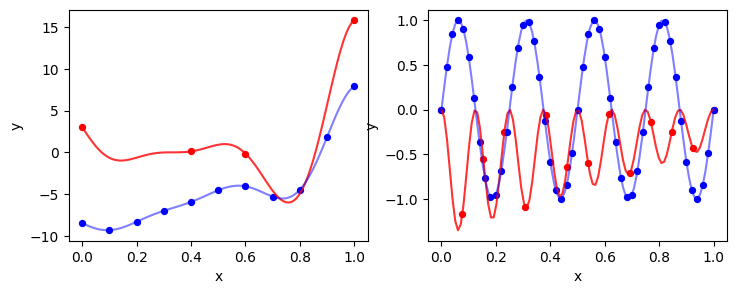

In [6]:
x = np.linspace(-0.0, 1.0, 100).reshape(-1, 1)

x_low_linear = np.linspace(0, 1, 11).reshape(-1, 1)
x_high_linear = np.array([[0, 0.4, 0.6, 1]]).reshape(-1, 1)

x_low_nonlinear = np.linspace(0, 1, 51).reshape(-1, 1)
x_high_nonlinear = np.linspace(0, 1, 14).reshape(-1, 1)

fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize=(8.5,3))

dashed_style = (0, (5, 4))

ax[0].plot(x, high_fidelity_linear(x), 'r', alpha = 0.8) # high-fidelity analytical
ax[0].plot(x, low_fidelity_linear(0.5, 10, -5, x), 'b', alpha = 0.5) # low-fidelity analytical
ax[0].scatter(x_high_linear, high_fidelity_linear(x_high_linear), s=18, color = 'r') # high-fidelity training points
ax[0].scatter(x_low_linear, low_fidelity_linear(0.5, 10, -5, x_low_linear), s=18, color = 'b') # low-fidelity training points
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].plot(x, high_fidelity_nonlinear(x, low_fidelity_nonlinear(x)), 'r', alpha = 0.8) # high-fidelity analytical
ax[1].plot(x, low_fidelity_nonlinear(x), 'b', alpha = 0.5) # low-fidelity analytical
ax[1].scatter(x_high_nonlinear, high_fidelity_nonlinear(x_high_nonlinear, low_fidelity_nonlinear(x_high_nonlinear)), s=18, color = 'r') # high-fidelity training points
ax[1].scatter(x_low_nonlinear, low_fidelity_nonlinear(x_low_nonlinear), s=18, color = 'b') # low-fidelity training points
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')

In [9]:
X_H_linear = torch.tensor(x_high_linear, dtype=torch.float32).to(device)
Y_H_linear = torch.tensor(high_fidelity_linear(x_high_linear), dtype=torch.float32).to(device)

nn_H = singlefidelity_NN([2,60],
                         [X_H_linear, Y_H_linear],
                         0*1e-2,
                         20000,
                         1e-4,
                         bnn=False,
                         device=device)

Activation: Tanh
Activation: Tanh
epoch: 1000,                    loss = 27.4897
epoch: 2000,                    loss = 14.0552
epoch: 3000,                    loss = 3.8351
epoch: 4000,                    loss = 1.9231
epoch: 5000,                    loss = 0.1464
epoch: 6000,                    loss = 0.0001
epoch: 7000,                    loss = 0.0000
epoch: 8000,                    loss = 0.0000
epoch: 9000,                    loss = 0.0000
epoch: 10000,                    loss = 0.0000
epoch: 11000,                    loss = 0.0000
epoch: 12000,                    loss = 0.0000
epoch: 13000,                    loss = 0.0000
epoch: 14000,                    loss = 0.0000
epoch: 15000,                    loss = 0.0000
epoch: 16000,                    loss = 0.0000
epoch: 17000,                    loss = 0.0000
epoch: 18000,                    loss = 0.0000
epoch: 19000,                    loss = 0.0000
epoch: 20000,                    loss = 0.0000
Model optimized


In [11]:
nn_H.eval()

X = torch.tensor(x, dtype=torch.float32).to(device)

with torch.no_grad():
    output_mc_HF = []
    for mc_run in range(100):
        predictions_high_linear = nn_H(X).to(device)
        output_mc_HF.append(predictions_high_linear)
    output_HF = torch.stack(output_mc_HF)
    pred_mean_HF = output_HF.mean(dim=0)
    pred_std_HF = output_HF.std(dim=0)

sf_predictions_high_linear = pred_mean_HF
sf_std_high_linear = pred_std_HF

In [12]:
X_L_linear = torch.tensor(x_low_linear, dtype=torch.float32).to(device)
Y_L_linear = torch.tensor(low_fidelity_linear(0.5, 10, -5, x_low_linear), dtype=torch.float32).to(device)
X_H_linear = torch.tensor(x_high_linear, dtype=torch.float32).to(device)
Y_H_linear = torch.tensor(high_fidelity_linear(x_high_linear), dtype=torch.float32).to(device)

nn_L, nn_H1, nn_H2 = multifidelity_NN([2, 60],
                                      [2, 60],
                                      [X_L_linear, Y_L_linear],
                                      [X_H_linear, Y_H_linear],
                                      [1e-3, 0, 1e-2],
                                      20000,
                                      1e-4,
                                      bnn=False,
                                      device=device)

Activation: Tanh
Activation: Tanh
Activation: None
Activation: None
Activation: Tanh
Activation: Tanh
epoch: 1000,                    loss = 12.0468
epoch: 2000,                    loss = 6.1730
epoch: 3000,                    loss = 5.4403
epoch: 4000,                    loss = 4.0850
epoch: 5000,                    loss = 2.4602
epoch: 6000,                    loss = 1.5127
epoch: 7000,                    loss = 1.1486
epoch: 8000,                    loss = 0.8147
epoch: 9000,                    loss = 0.5711
epoch: 10000,                    loss = 0.4506
epoch: 11000,                    loss = 0.3670
epoch: 12000,                    loss = 0.2956
epoch: 13000,                    loss = 0.2398
epoch: 14000,                    loss = 0.2017
epoch: 15000,                    loss = 0.1767
epoch: 16000,                    loss = 0.1629
epoch: 17000,                    loss = 0.1558
epoch: 18000,                    loss = 0.1518
epoch: 19000,                    loss = 0.1492
epoch: 20000,

In [13]:
nn_L.eval()
nn_H1.eval()
nn_H2.eval()

X = torch.tensor(x, dtype=torch.float32).to(device)

with torch.no_grad():
    output_mc_LF = []
    output_mc_HF = []
    for mc_run in range(100):
        predictions_low_linear = nn_L(X)
        predictions_high_linear = (nn_H1(torch.concatenate([X, predictions_low_linear], 1)) + nn_H2(torch.concatenate([X, predictions_low_linear], 1)))
        output_mc_LF.append(predictions_low_linear)
        output_mc_HF.append(predictions_high_linear)
    output_LF = torch.stack(output_mc_LF)
    output_HF = torch.stack(output_mc_HF)
    pred_mean_LF = output_LF.mean(dim=0)
    pred_std_LF = output_LF.std(dim=0)
    pred_mean_HF = output_HF.mean(dim=0)
    pred_std_HF = output_HF.std(dim=0)

mf_predictions_low_linear = pred_mean_LF
mf_predictions_high_linear = pred_mean_HF
mf_std_low_linear = pred_std_LF
mf_std_high_linear = pred_std_HF

In [14]:
X_H_nonlinear = torch.tensor(x_high_nonlinear, dtype=torch.float32).to(device)
Y_H_nonlinear = torch.tensor(high_fidelity_nonlinear(x_high_nonlinear, low_fidelity_nonlinear(x_high_nonlinear)), dtype=torch.float32).to(device)

nn_H = singlefidelity_NN([2,60],
                         [X_H_nonlinear, Y_H_nonlinear],
                         0*1e-2,
                         20000,
                         1e-3,
                         bnn=False,
                         device=device)

Activation: Tanh
Activation: Tanh
epoch: 1000,                    loss = 0.1226
epoch: 2000,                    loss = 0.1148
epoch: 3000,                    loss = 0.0699
epoch: 4000,                    loss = 0.0334
epoch: 5000,                    loss = 0.0194
epoch: 6000,                    loss = 0.0082
epoch: 7000,                    loss = 0.0013
epoch: 8000,                    loss = 0.0024
epoch: 9000,                    loss = 0.0000
epoch: 10000,                    loss = 0.0000
epoch: 11000,                    loss = 0.0031
epoch: 12000,                    loss = 0.0000
epoch: 13000,                    loss = 0.0000
epoch: 14000,                    loss = 0.0024
epoch: 15000,                    loss = 0.0000
epoch: 16000,                    loss = 0.0000
epoch: 17000,                    loss = 0.0000
epoch: 18000,                    loss = 0.0000
epoch: 19000,                    loss = 0.0000
epoch: 20000,                    loss = 0.0000
Model optimized


In [15]:
nn_H.eval()

X = torch.tensor(x, dtype=torch.float32).to(device)

with torch.no_grad():
    output_mc_HF = []
    for mc_run in range(100):
        predictions_high_nonlinear = nn_H(X)
        output_mc_HF.append(predictions_high_nonlinear)
    output_HF = torch.stack(output_mc_HF)
    pred_mean_HF = output_HF.mean(dim=0)
    pred_std_HF = output_HF.std(dim=0)

sf_predictions_high_nonlinear = pred_mean_HF
sf_std_high_nonlinear = pred_std_HF

In [17]:
X_L_nonlinear = torch.tensor(x_low_nonlinear, dtype=torch.float32).to(device)
Y_L_nonlinear = torch.tensor(low_fidelity_nonlinear(x_low_nonlinear), dtype=torch.float32).to(device)
X_H_nonlinear = torch.tensor(x_high_nonlinear, dtype=torch.float32).to(device)
Y_H_nonlinear = torch.tensor(high_fidelity_nonlinear(x_high_nonlinear, low_fidelity_nonlinear(x_high_nonlinear)), dtype=torch.float32).to(device)

nn_L, nn_H1, nn_H2 = multifidelity_NN([2, 60],
                                      [2, 60],
                                      [X_L_nonlinear, Y_L_nonlinear],
                                      [X_H_nonlinear, Y_H_nonlinear],
                                      [1e-4, 1e-4, 1e-4],
                                      30000,
                                      1e-3,
                                      bnn=False,
                                      device=device)

Activation: Tanh
Activation: Tanh
Activation: None
Activation: None
Activation: Tanh
Activation: Tanh
epoch: 1000,                    loss = 0.6130
epoch: 2000,                    loss = 0.6011
epoch: 3000,                    loss = 0.5558
epoch: 4000,                    loss = 0.5000
epoch: 5000,                    loss = 0.2564
epoch: 6000,                    loss = 0.1011
epoch: 7000,                    loss = 0.0638
epoch: 8000,                    loss = 0.0558
epoch: 9000,                    loss = 0.0475
epoch: 10000,                    loss = 0.0369
epoch: 11000,                    loss = 0.0306
epoch: 12000,                    loss = 0.0299
epoch: 13000,                    loss = 0.0255
epoch: 14000,                    loss = 0.0242
epoch: 15000,                    loss = 0.0233
epoch: 16000,                    loss = 0.0227
epoch: 17000,                    loss = 0.0222
epoch: 18000,                    loss = 0.0218
epoch: 19000,                    loss = 0.0214
epoch: 20000, 

In [18]:
nn_L.eval()
nn_H1.eval()
nn_H2.eval()

X = torch.tensor(x, dtype=torch.float32).to(device)

with torch.no_grad():
    output_mc_LF = []
    output_mc_HF = []
    for mc_run in range(1000):
        predictions_low_nonlinear = nn_L(X)
        predictions_high_nonlinear = (nn_H1(torch.concatenate([X, predictions_low_nonlinear], 1)) + nn_H2(torch.concatenate([X, predictions_low_nonlinear], 1)))
        output_mc_LF.append(predictions_low_nonlinear)
        output_mc_HF.append(predictions_high_nonlinear)
    output_LF = torch.stack(output_mc_LF)
    output_HF = torch.stack(output_mc_HF)
    pred_mean_LF = output_LF.mean(dim=0)
    pred_std_LF = output_LF.std(dim=0)
    pred_mean_HF = output_HF.mean(dim=0)
    pred_std_HF = output_HF.std(dim=0)

mf_predictions_low_nonlinear = pred_mean_LF
mf_predictions_high_nonlinear = pred_mean_HF
mf_std_low_nonlinear = pred_std_LF
mf_std_high_nonlinear = pred_std_HF

Text(0, 0.5, 'y')

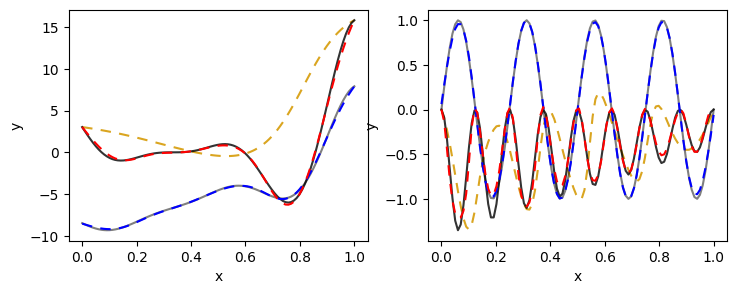

In [21]:
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize=(8.5,3))

dashed_style = (0, (5, 4))

ax[0].plot(x, sf_predictions_high_linear.cpu(), linewidth=1.5, linestyle= dashed_style, color = 'goldenrod', zorder = 1) # high-fidelity predictions
ax[0].plot(x, mf_predictions_high_linear.cpu(), linewidth=1.5, linestyle=dashed_style, color = 'r', zorder = 10) # high-fidelity predictions
ax[0].plot(x, mf_predictions_low_linear.cpu(), linewidth=1.5, linestyle=dashed_style, color = 'b', zorder = 5) # low-fidelity predictions
ax[0].plot(x, high_fidelity_linear(x), 'k', alpha = 0.8) # high-fidelity analytical
ax[0].plot(x, low_fidelity_linear(0.5, 10, -5, x), 'k', alpha = 0.5) # low-fidelity analytical
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
#ax[0].scatter(x_high_linear, high_fidelity_linear(x_high_linear), s=18, color = 'r') # high-fidelity training points

ax[1].plot(x, sf_predictions_high_nonlinear.cpu(), linewidth=1.5, linestyle=dashed_style, color = 'goldenrod', zorder = 1) # high-fidelity predictions
ax[1].plot(x, mf_predictions_high_nonlinear.cpu(), linewidth=1.5, linestyle=dashed_style, color = 'r', zorder = 10) # high-fidelity predictions
ax[1].plot(x, mf_predictions_low_nonlinear.cpu(), linewidth=1.5, linestyle=dashed_style, color = 'b', zorder = 5) # low-fidelity predictions
ax[1].plot(x, high_fidelity_nonlinear(x, low_fidelity_nonlinear(x)), 'k', alpha = 0.8) # high-fidelity analytical
ax[1].plot(x, low_fidelity_nonlinear(x), 'k', alpha = 0.5) # low-fidelity analytical
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
#ax[1].scatter(x_high_nonlinear, high_fidelity_nonlinear(x_high_nonlinear, low_fidelity_nonlinear(x_high_nonlinear)), s=18, color = 'r') # high-fidelity training points